In [1]:
 #pip install gurobipy

In [2]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## function : Run Model with input data

In [5]:
def run_model(
    scenario, 
    Lmin_t,
    Lmax_t,
    Pt_PV,
    ct_PV,
    pt,
    Emin,
    max_import_kW,
    max_export_kW,
    tau_imp,
    tau_exp,
):
    """
    Runs the optimization model for energy scheduling with PV, grid import/export, and flexible load.
    """

    # Make model
    model = gp.Model("Scenario")
    HOURS = list(range(24))

    ## deafult upper bound and lower bound of each variable
    ## TODO are bounds correct?
    lb = 0.0
    ub = float('inf')

    # one var for every t:
    # Lt: load consumption (kWh).
    Lt = {t: model.addVar(Lmin_t, Lmax_t, vtype=GRB.CONTINUOUS, name='L{0}'.format(t)) for t in HOURS}

    # ut: Energy not curtailed (kWh).
    ut= {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='s{0}'.format(t)) for t in HOURS}

    # ct: PV curtailed (kWh).
    ct = {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='c{0}'.format(t)) for t in HOURS}

    # gt_imp : grid import (kWh).
    gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name='g{0}_imp'.format(t)) for t in HOURS}

    # gt_exp : grid export (kWh).
    gt_exp = {t: model.addVar(lb, max_export_kW, vtype=GRB.CONTINUOUS, name='g{0}_exp'.format(t)) for t in HOURS}

    model.update()
    vars = model.getVars()
    # print("added " +str(len(vars)) + " variables")

    # (Load bounds) 0 ≤ Lt ≤ Lmaxt ,
    # This has been implemented in variable definitinon, where upper and lower bound of variable have been set to Lmax_t and Lmin_t

    # (Daily minimum consumption) SUM(Lt) ≥ Emin,
    constraints = [
            (
                    model.addLConstr(
                            gp.quicksum(Lt[t] for t in HOURS),
                            GRB.GREATER_EQUAL,
                            Emin,
                            name="Daily_minimum"
                    )
            )
    ]

    # (PV allocation) ut + ct = Pt_PV
    # (Energy balance at consumer node) ut + gt_imp = Lt + gt_exp 
    for t in HOURS :
        model.addLConstr(ut[t] + ct[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation')
        model.addLConstr(ut[t] + gt_imp[t], GRB.EQUAL , Lt[t] + gt_exp[t], name='Energy_balance_at_node')

    model.update()

    # Objective
    model.setObjective(
        gp.quicksum(
            (pt[t] + tau_imp) * gt_imp[t] - (pt[t] + tau_exp) * gt_exp[t]  + ct_PV*Pt_PV[t]
            for t in HOURS
        ), GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check the optimization status
    if model.status == GRB.OPTIMAL:
        print("Optimization {i} successful!".format(i = scenario))
        # You can access the optimal objective value and variable values here
        print("Optimal objective value:", model.ObjVal)
        for v in model.getVars():
            if v.X > 1e-6: # Print only variables with non-zero values
                print(v.VarName, v.X)
    elif model.status == GRB.INFEASIBLE:
        print("Model is infeasible")
    elif model.status == GRB.UNBOUNDED:
        print("Model is unbounded")
    else:
        print("Optimization ended")

    ## 
    ## PLOT 1 : everything
    ##

    # Extract variable values from the optimization results
    Lt_values = [Lt[t].X for t in HOURS]
    ut_values = [ut[t].X for t in HOURS]
    ct_values = [ct[t].X for t in HOURS]
    gt_imp_values = [gt_imp[t].X for t in HOURS]
    gt_exp_values = [gt_exp[t].X for t in HOURS]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(HOURS, Lt_values, label='Load Consumption (Lt)', alpha=0.7, marker='o')
    plt.plot(HOURS, ut_values, label='PV not curtailed (ut)', alpha=0.7, marker='s')
    plt.plot(HOURS, ct_values, label='PV Curtailed (ct)', alpha=0.7, marker='^')
    #plt.plot(HOURS, gt_imp_values, label='Grid Import (gt_imp)', alpha=0.7, marker='x')
    plt.plot(HOURS, gt_exp_values, label='Grid Export (gt_exp)', alpha=0.7, marker='D')
    plt.plot(HOURS, Pt_PV, label='PV Production (Pt_PV)', alpha=0.7, marker='*')

    # Add labels and title
    plt.xlabel('Hour')
    plt.ylabel('Value (kWh)')
    plt.title('Scenario {i}: All Decision Variable Values Over Time (vs. PV_production)'.format(i = scenario))
    plt.xticks(HOURS)
    plt.legend()
    plt.grid(True)
    plt.show()

    ##
    ## PLOT 2 : import & export behaviour
    ##

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot energy price on the first y-axis
    color = 'tab:red'
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Energy Price (DKK/kWh)', color=color)
    ax1.plot(HOURS, pt, color=color, marker='o', label='Energy price(DKK/kWh)')
    ax1.plot(HOURS, np.repeat(tau_imp, 24), color='tab:orange',  label='Import tariff (DKK/kWh)')
    ax1.plot(HOURS, np.repeat(tau_exp, 24), color='tab:pink',  label='Export tariff (DKK/kWh)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create a second y-axis for import/export
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Energy Amount (kWh)', color=color)
    ax2.plot(HOURS, gt_imp_values, color='tab:blue', marker='x', linestyle='dashed', label='Grid Import(kWh)')
    ax2.plot(HOURS, gt_exp_values, color='tab:green', marker='D', linestyle='dashed', label='Grid Export(kWh)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and legend
    plt.title('Scenario {i} : Energy Price vs. Grid Import/Export Over Time'.format(i = scenario))
    fig.tight_layout() # To prevent labels overlapping
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.xticks(HOURS)
    plt.show()

    return {
        "Lt": Lt_values,
        "ut": ut_values,
        "ct": ct_values,
        "gt_imp": gt_imp_values,
        "gt_exp": gt_exp_values,
        "objective": model.ObjVal if model.status == GRB.OPTIMAL else None,
    }


# Load & run each scenario


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x994bd5a0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 49 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9265000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.926500000e+01
Optimization 1 successful!
Optimal objective value: 29.265000000001237
L12 3.0
L13 3.0
L14 3.0
L15 3.0
L16 3.0
L17 3.0
L18

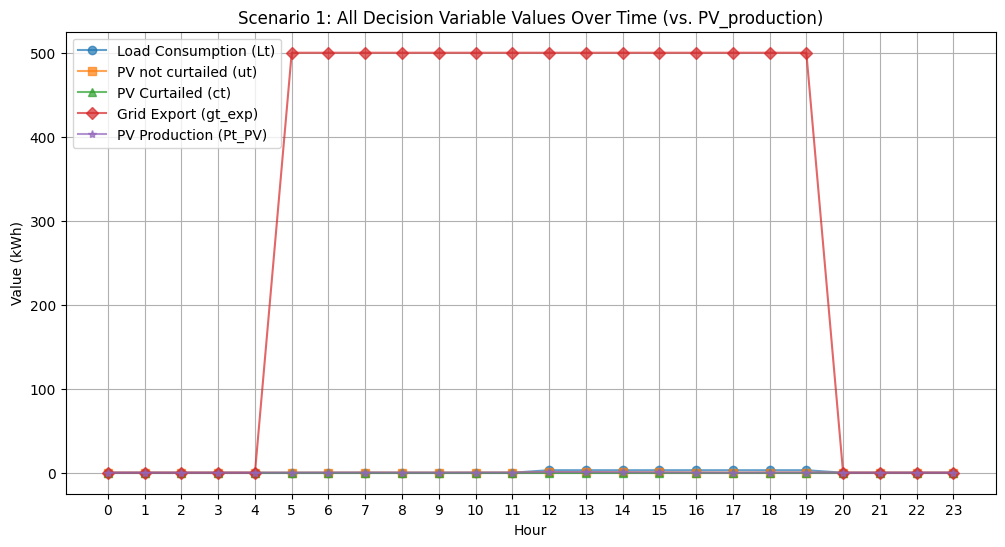

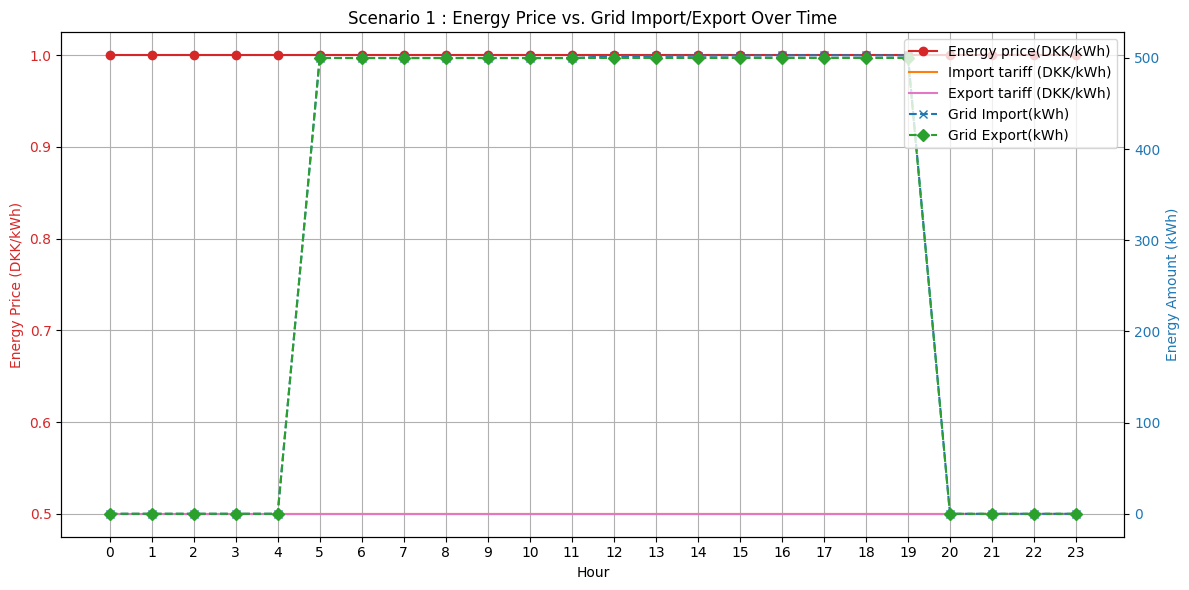

In [ ]:
import json
import csv

#for each scenario
for i in [0,1]: 
    
    # load JSONs
    with open('../data/scenario_{i}/bus_params.json'.format(i = i), 'r') as file:
        bus_params = json.load(file)
    #print(json.dumps(bus_params, indent=4))
    with open('../data/scenario_{i}/DER_production.json'.format(i = i), 'r') as file:
        der_production = json.load(file)
    #print(json.dumps(der_production, indent=4))

    with open('../data/scenario_{i}/appliance_params.json'.format(i = i), 'r') as file:
        appl_params= json.load(file)
    #print(json.dumps(appl_params, indent=4))

    with open('../data/scenario_{i}/usage_preference.json'.format(i = i), 'r') as file:
        usage_preference= json.load(file)
    #print(json.dumps(usage_preference, indent=4))


    # Read relevant fields from JSONs
    # Lmin_t : minimum hourly flexible load (kWh/h). Lmint = 0 here because the load is fully flexible.
    Lmin_t = 0.0
    # Lmax_t : maximum hourly flexible load (kWh/h).
    Lmax_t = appl_params["load"][0]["max_load_kWh_per_hour"]
    # Pt_PV : Hourly available PV production (kWh/h).
    Pt_PV = der_production[0]["hourly_profile_ratio"] # TODO not sure if this is the correct array but the only one i could find aside from cost
    # ct_PV : marginal PV production cost (DKK/kWh).
    ct_PV = 0 #  TODO could not find PV production cost  in JSON, assuming this implies PV energy is free
    # pt: electricity price (DKK/kWh).
    pt = bus_params[0]["energy_price_DKK_per_kWh"]

    #Emin: minimum daily required energy consumption (kWh) ,  expressed as # of hours equivalent at maximum capacity
    Emin_hour_equivalent = usage_preference[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"] 
    Emin = Emin_hour_equivalent * Lmax_t

    #gt_imp_max and gt_exp_max
    max_import_kW = bus_params[0]["max_import_kW"]
    max_export_kW = bus_params[0]["max_export_kW"]

    #tau_imp and tau_export : are the tariffs per hour? (DKK/kWh)
    tau_imp = bus_params[0]["import_tariff_DKK/kWh"]
    tau_exp = bus_params[0]["export_tariff_DKK/kWh"]

    # TODO are we allowed to go over? 1st question doesnt mention this but do we need to for another?
    penalty_excess_import = bus_params[0]["penalty_excess_import_DKK/kWh"]
    penalty_excess_export = bus_params[0]["penalty_excess_export_DKK/kWh"]
    
    
    ##
    ## run model on scenario
    ##
    results = run_model(
        scenario = i,
    Lmin_t=0.0,
    Lmax_t=appl_params["load"][0]["max_load_kWh_per_hour"],
    Pt_PV=der_production[0]["hourly_profile_ratio"],
    ct_PV=0,
    pt=bus_params[0]["energy_price_DKK_per_kWh"],
    Emin=usage_preference[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"] 
         * appl_params["load"][0]["max_load_kWh_per_hour"],
    max_import_kW=bus_params[0]["max_import_kW"],
    max_export_kW=bus_params[0]["max_export_kW"],
    tau_imp=bus_params[0]["import_tariff_DKK/kWh"],
    tau_exp=bus_params[0]["export_tariff_DKK/kWh"],
    )

    
    
    
    

